# **Airbnb Investment Analysis**

by Mikael Makonnen

The goal of this analysis is to provide investors with valuable advice on where to buy an investment property to rent out as an Airbnb. This analysis considers cities worldwide, with a separate focus on identifying the best investment opportunities within and outside of Europe. Additionally, it briefly explores the characteristics these investment properties should have. The extensive listings data is employed for this purpose. The analysis follows this structure:

**1) Loading and Preparing the data for the analysis**

**2) Exploratory Data Analysis**

2.1) Descriptive Analytics Analysis

2.2) Price Analysis

2.3) Correlation Analysis

2.4) Analysis of Reviews

2.5) Summary

**3) Revenue Analysis + Profitability Esimtation + Investment Advice**

3.1) Revenue Calculation

3.2) Revenue Analysis

3.3) Profitability Esimtation + Investment Advice

#**1) Loading and Preparing the data for the analysis**

We begin by loading the data for the analysis and by preprocessing it accordingly.

In this section, we will also split the data dividing it between European countries and non-European countries, this is done in order to continue with our objective and analysis.

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
import statsmodels.api as sm
import plotly.express as px

In [2]:
# connect to google drive for the data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Functions used

# Function to load the datasets conveniently
def serial_reading(city, file, columns):
    file_rel_path = path + "/" + city + "/" + file
    return pd.read_csv(file_rel_path, usecols=columns)

# Function to summarize aspects of the dataframe relevant for preprocessing
def pre_process_helper(df, name_df):
    separator = "#" * 25

    print(f"Dimensions of dataframe ({name_df}):\n{df.shape}\n")
    print(separator)

    print(f"Datatypes in dataframe ({name_df}):\n{df.dtypes}\n")
    print(separator)

    print(f"Cardinality of features ({name_df}):\n{df.nunique()}\n")
    print(separator)

    print(f"Percentage of missing entries per feature ({name_df}):\n{df.isnull().mean()}\n")
    print(separator)

    print(f"Small sample from the data ({name_df}):")
    display(df.head(2))

In [4]:
# Load data and create Europe and non-Europe dataframes with all listings, adding city and continent columns

# Directory of files
path = '/content/drive/MyDrive/ECB_application/data/Final airbnb data'

# Cities
cities = [
    "Amsterdam", "Barcelona", "Euskadi", "Geneva", "Ireland", "Lisbon",
    "Los Angeles", "Madrid", "Malaga", "Mallorca", "Malta", "Menorca",
    "Mexico City", "Milan", "Naples", "New Zeland", "Rome", "Rotterdam",
    "San Diego", "San Francisco", "Tokyo", "Toronto", "Valencia",
    "Vancouver", "Vienna", "Washington", "Winnipeg", "Zurich"
]

# Countries (used for map)
countries = [
    'NLD', 'ESP', 'ESP', 'CHE', 'IRL', 'PRT', 'USA', 'ESP', 'ESP', 'ESP', 'MLT', 'ESP',
    'MEX', 'ITA', 'ITA', 'NZL', 'ITA', 'NLD', 'USA', 'USA', 'JPN', 'CAN', 'ESP', 'CAN',
    'AUT', 'USA', 'CAN', 'CHE'
]

# Continents
continents = [
    'Europe', 'Europe', 'Europe', 'Europe', 'Europe', 'Europe', 'Non-Europe', 'Europe',
    'Europe', 'Europe', 'Europe', 'Europe', 'Non-Europe', 'Europe', 'Europe', 'Non-Europe',
    'Europe', 'Europe', 'Non-Europe', 'Non-Europe', 'Non-Europe', 'Non-Europe', 'Europe',
    'Non-Europe', 'Europe', 'Non-Europe', 'Non-Europe', 'Europe'
]

# Listing attributes (initially chosen based on their potential interest for analysis)
listings_attributes = [
    'id', 'name', 'description', 'host_id', 'host_since', 'host_is_superhost',
    'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
    'amenities', 'price', 'minimum_nights', 'maximum_nights', 'availability_30',
    'availability_60', 'availability_90', 'availability_365', 'number_of_reviews_ltm',
    'number_of_reviews_l30d', 'review_scores_rating'
]

# Load files and combine data for all cities
all_dfs = []
for i, city in enumerate(cities):
    city_df = serial_reading(city, "listings.csv", listings_attributes)
    city_df["City"] = cities[i]
    city_df["Country"] = countries[i]
    city_df["Continent"] = continents[i]
    all_dfs.append(city_df)

# Concatenate data for all cities and create Europe and non-Europe dataframes
all_listings = pd.concat(all_dfs).reset_index(drop=True)
all_listings_Europe = all_listings[all_listings["Continent"] == "Europe"].reset_index(drop=True)
all_listings_non_Europe = all_listings[all_listings["Continent"] != "Europe"].reset_index(drop=True)

# NOTE: Use only all_listings_Europe and all_listings_non_Europe dataframes from here

# Clear memory of unnecessary variables
del all_dfs, all_listings

Now that we have loaded the data and made a Europe and non-Europe dataframe with all listings (including city and Continent indicators) we next preprocess the data before being able to analyze it more thouroughly. For this we first look at some characteristics of the dataframes.

In [5]:
# employ functions defined earlier to conveniently show dtypes, missing values...
pre_process_helper(all_listings_Europe, 'Europe')
pre_process_helper(all_listings_non_Europe, 'non_Europe')

Dimensions of dataframe (Europe):
(213413, 26)

#########################
Datatypes in dataframe (Europe):
id                          int64
name                       object
description                object
host_id                     int64
host_since                 object
host_is_superhost          object
property_type              object
room_type                  object
accommodates                int64
bathrooms                 float64
bedrooms                  float64
beds                      float64
amenities                  object
price                      object
minimum_nights              int64
maximum_nights              int64
availability_30             int64
availability_60             int64
availability_90             int64
availability_365            int64
number_of_reviews_ltm       int64
number_of_reviews_l30d      int64
review_scores_rating      float64
City                       object
Country                    object
Continent                  object
dtype: ob

,id,name,description,host_id,host_since,host_is_superhost,property_type,room_type,accommodates,bathrooms,...,availability_30,availability_60,availability_90,availability_365,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,City,Country,Continent
0,2818,Quiet Garden View Room & Super Fast WiFi,Quiet Garden View Room & Super Fast WiFi<br />...,3159,2008-09-24,t,Private room in rental unit,Private room,2,NaN,...,1,9,14,14,25,1,4.89,Amsterdam,NLD,Europe
1,20168,Studio with private bathroom in the centre 1,17th century Dutch townhouse in the heart of t...,59484,2009-12-02,f,Private room in townhouse,Private room,2,NaN,...,0,0,0,0,0,0,4.44,Amsterdam,NLD,Europe


Dimensions of dataframe (non_Europe):
(167161, 26)

#########################
Datatypes in dataframe (non_Europe):
id                          int64
name                       object
description                object
host_id                     int64
host_since                 object
host_is_superhost          object
property_type              object
room_type                  object
accommodates                int64
bathrooms                 float64
bedrooms                  float64
beds                      float64
amenities                  object
price                      object
minimum_nights              int64
maximum_nights              int64
availability_30             int64
availability_60             int64
availability_90             int64
availability_365            int64
number_of_reviews_ltm       int64
number_of_reviews_l30d      int64
review_scores_rating      float64
City                       object
Country                    object
Continent                  object
d

,id,name,description,host_id,host_since,host_is_superhost,property_type,room_type,accommodates,bathrooms,...,availability_30,availability_60,availability_90,availability_365,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,City,Country,Continent
0,183319,Panoramic Ocean View Venice Beach,Craftsmen style penthouse with ocean view from...,867995,2011-07-25,f,Entire rental unit,Entire home/apt,2,NaN,...,0,0,0,0,0,0,5.00,Los Angeles,USA,Non-Europe
1,51307,Spanish Bungalow Guest House LA CA. 30 plus ni...,PRIVATE GUEST HOUSE<br /><br /><b>The space</b...,235568,2010-09-15,f,Entire bungalow,Entire home/apt,2,NaN,...,0,2,3,224,0,0,4.64,Los Angeles,USA,Non-Europe


From the previous process we can figure out what other steps need to be done in order to correctly clean the data:

1. Get rid of columns fully consisting of NA's. For example, bathrooms in both dataframes which has 100% NA values.
2. Convert some datatypes.
    - Change price to numeric format
    - Converting host_since from string to datatime format
    - convert host_is_superhost feature to boolean

3. Use exchange rates to convert all prices into one currency using the one year average exchange rate
    - Selected Currency = Euro

This we do in the next step.

**1. Dropping column consisting of NA Values**


In [6]:
# drop bathroom column only consisting of NA's
all_listings_Europe = all_listings_Europe.drop(columns = 'bathrooms')
all_listings_non_Europe = all_listings_non_Europe.drop(columns = 'bathrooms')

**2. Converting Datatypes**

In [7]:
# format host_since feature

# convert from string to datetime format
all_listings_Europe['host_since'] = pd.to_datetime(all_listings_Europe['host_since'],
                                                   infer_datetime_format = True)
all_listings_non_Europe['host_since'] = pd.to_datetime(all_listings_non_Europe['host_since'],
                                                       infer_datetime_format = True)

# format host_is_superhost feature

# convert t and f to True and False
all_listings_Europe['host_is_superhost'].replace(['t', 'f'], [True, False], inplace = True)
all_listings_non_Europe['host_is_superhost'].replace(['t', 'f'], [True, False], inplace = True)

<ipython-input-7-9d0fb4fc6fab>:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  all_listings_Europe['host_since'] = pd.to_datetime(all_listings_Europe['host_since'],
<ipython-input-7-9d0fb4fc6fab>:6: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  all_listings_non_Europe['host_since'] = pd.to_datetime(all_listings_non_Europe['host_since'],


**3. Convert all currencies to EURO**

In [8]:
# Format the price feature

# NOTE: The "$" symbol in the data is misleading. Based on the EDA, it was found that the dataset
# contains prices in different currencies. Prices will be reformatted and adjusted using
# a one-year average exchange rate to convert all values to EUR.

# Reformat the price column to numeric by removing "$" and "," characters
all_listings_Europe['price'] = pd.to_numeric(all_listings_Europe['price'].str.replace("$", "").str.replace(",", ""))
all_listings_non_Europe['price'] = pd.to_numeric(all_listings_non_Europe['price'].str.replace("$", "").str.replace(",", ""))

# Currency adjustment: exchange rates (one-year average) to EUR
exchange_rates = {
    'swiss_fra_ex': 1.00,
    'canada_dol_ex': 0.73,
    'usa_dol_ex': 0.95,
    'jap_yen_ex': 0.007,
    'newz_dol_ex': 0.60,
    'mex_pes_ex': 0.05
}

# Apply currency adjustments

# Switzerland (Geneva, Zurich)
all_listings_Europe['price'] = np.where(all_listings_Europe['City'].isin(['Geneva', 'Zurich']),
                                        all_listings_Europe['price'] * exchange_rates['swiss_fra_ex'],
                                        all_listings_Europe['price'])

# USA (Los Angeles, San Diego, San Francisco, Washington)
usa_cities = ["Los Angeles", "San Diego", "San Francisco", "Washington"]
all_listings_non_Europe['price'] = np.where(all_listings_non_Europe['City'].isin(usa_cities),
                                            all_listings_non_Europe['price'] * exchange_rates['usa_dol_ex'],
                                            all_listings_non_Europe['price'])

# Canada (Toronto, Vancouver, Winnipeg)
canadian_cities = ["Toronto", "Vancouver", "Winnipeg"]
all_listings_non_Europe['price'] = np.where(all_listings_non_Europe['City'].isin(canadian_cities),
                                            all_listings_non_Europe['price'] * exchange_rates['canada_dol_ex'],
                                            all_listings_non_Europe['price'])

# Mexico (Mexico City)
all_listings_non_Europe['price'] = np.where(all_listings_non_Europe['City'] == "Mexico City",
                                            all_listings_non_Europe['price'] * exchange_rates['mex_pes_ex'],
                                            all_listings_non_Europe['price'])

# New Zealand (New Zeland)
all_listings_non_Europe['price'] = np.where(all_listings_non_Europe['City'] == "New Zeland",
                                            all_listings_non_Europe['price'] * exchange_rates['newz_dol_ex'],
                                            all_listings_non_Europe['price'])

# Japan (Tokyo)
all_listings_non_Europe['price'] = np.where(all_listings_non_Europe['City'] == "Tokyo",
                                            all_listings_non_Europe['price'] * exchange_rates['jap_yen_ex'],
                                            all_listings_non_Europe['price'])

#**2) Exploratory Data Analysis**

In this section, we will explore each of the two databases that were created (one for Europe and one for non-Europe). The goal of this EDA is to find out the general underlying structure of our data, to increase our understanding of it, and to get some general insights.

**The structure of the EDA will consist of the following sections:**
1. Descriptive analytics
2. Price analysis
3. Correlation analysis
4. Analysis of reviews

All of the previous points are crucial in order to continue with the analysis that will be done later on.

### **2.1) Descriptive Analytics Analysis**

#### **Europe**

First of all, we begin with the general descriptive analytics of both our datasets, which is shown below:

In [9]:
# Set the display format for floats
pd.options.display.float_format = "{:.2f}".format

# Select columns for descriptive statistics in Europe listings
descriptive_cols = [
    "accommodates", "bedrooms", "beds", "price", "minimum_nights", "availability_30",
    "availability_60", "availability_90", "availability_365", "number_of_reviews_ltm",
    "number_of_reviews_l30d", "review_scores_rating"
]

# Create a DataFrame with selected columns and display descriptive statistics
Descriptive_Europe = all_listings_Europe[descriptive_cols]
Descriptive_Europe.describe()

,accommodates,bedrooms,beds,price,minimum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating
count,213413.00,202819.00,210481.00,213413.00,213413.00,213413.00,213413.00,213413.00,213413.00,213413.00,213413.00,177744.00
mean,3.82,1.77,2.51,172.44,5.49,8.58,22.18,38.83,176.54,10.58,1.08,4.66
std,2.34,1.16,1.98,726.66,25.55,9.81,20.57,31.92,133.94,18.32,1.94,0.56
min,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2.00,1.00,1.00,65.00,1.00,0.00,0.00,1.00,41.00,0.00,0.00,4.57
50%,4.00,1.00,2.00,102.00,2.00,4.00,18.00,40.00,173.00,3.00,0.00,4.80
75%,5.00,2.00,3.00,174.00,3.00,15.00,40.00,68.00,315.00,14.00,2.00,4.96
max,16.00,25.00,50.00,99149.00,1125.00,30.00,60.00,90.00,365.00,1250.00,126.00,5.00


Based on the previous table, we can see a couple of insteresting things. Firstly, we can see that the mean accomodates of an airbnb is 3.82, meaning that on average, airbnb apartments tend to allow 3-4 people. Additionally, the average price of all the cities is 172 euro each night and there seems to be between 1-2 rooms and 2-3 beds per airbnb on average in Europe. Additionaly, in terms of availability, we can see a trend in which, when we expand the number of days in the future, the number of nights available also increases. This tells us that people generally don't look that far into the future when renting out airbnbs.

Finally, in terms of reviews, we can see that the average rating is actually really high (4.66), and this is furthered backed up by the fact that the 25% percentile also shows a high rating of 4.57. However, the minimum rating is 0. This means that in terms of reviews, people generally tend to either rank an airbnb with a very good review or a very bad one.

**Counting the amount of data we have per city**

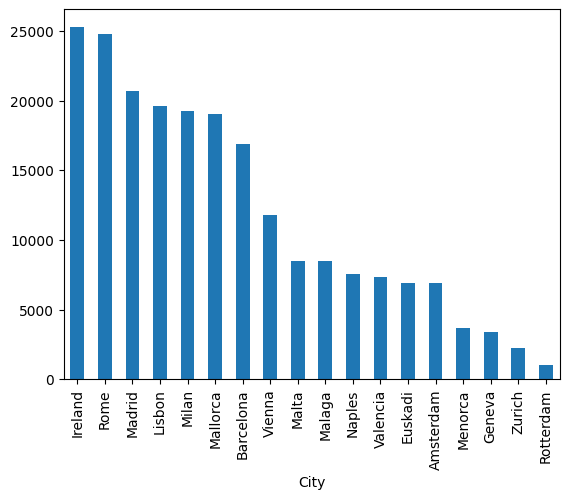

In [10]:
# Europe
all_listings_Europe['City'].value_counts().plot(kind='bar');

From the graph above we can see that Ireland is the one with the most entries, which is normal as it is a county whereas the others are cities (Except for Euskadi, which is a region from Spain). So by taking into account which ones are cities, the one with most entries is Rome Italy, followed by Madrid Spain, and Lisbon Portugal. These three cities are located in the south of Europe, so a primliminary hypothesis is that there are more listings in these cities because as they are the more touristic options.

The ones with less entries, meaning they may be less touristic, are Rotterdam, in the Netherlands, followed by Geneva and Zurich, in Switzerland. Rotterdam is located in the north Europe, with worse weather than the south, so this could be an important factor in regard to being a tourist destination. Then the following two cities are in Switzerland, which in Europe is known for being one of the most expensive countries to visit, so that could be a reason for less listings. Another reason for the lack of listings could be the aforementioned prices in thoes countries. It is most likely more expensive to buy property in those places making the barrier to entry higher. On the other hand, the south of Europe (Portugal, Spain and Italy) are place that have better weather but also have lower prices in general, we will examine this in more detail later in the analysis.

#### **Non-Europe**

In [11]:
# Non-Europe
Descriptive_non_Europe = all_listings_non_Europe[["accommodates","bedrooms","beds",
                                                  "price","minimum_nights",
                                                  "availability_30","availability_60",
                                                  "availability_90","availability_365",
                                                  "number_of_reviews_ltm",
                                                  "number_of_reviews_l30d",
                                                  "review_scores_rating"]]
Descriptive_non_Europe.describe()

,accommodates,bedrooms,beds,price,minimum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating
count,167161.00,155764.00,164442.00,167161.00,167161.00,167161.00,167161.00,167161.00,167161.00,167161.00,167161.00,137751.00
mean,3.97,1.80,2.34,203.52,11.76,12.22,28.32,46.70,180.18,10.77,0.96,4.73
std,2.71,1.19,1.91,790.77,30.68,11.40,22.61,33.84,133.00,19.17,1.90,0.53
min,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2.00,1.00,1.00,60.00,1.00,0.00,1.00,7.00,57.00,0.00,0.00,4.68
50%,3.00,1.00,2.00,108.00,2.00,10.00,30.00,53.00,173.00,3.00,0.00,4.87
75%,5.00,2.00,3.00,190.00,28.00,23.00,51.00,79.00,320.00,13.00,1.00,5.00
max,16.00,50.00,88.00,95000.00,1125.00,30.00,60.00,90.00,365.00,833.00,119.00,5.00


The previous table shows similar results to the European one. The mean accomodates per room is also between 3-4 peole, the average number of bedrooms seem to be between 1-2 and average number of beds between 2-3 just as the European descriptive analytics showed. The trend of availability is also backed up in this dataset with pretty similar results to the previous one. In terms of reviews, we can also see a similar trend were people tend to either rank the airbnb with a very high or very low rating, but usually high.

Counting the amount of data we have per city

<Axes: xlabel='City'>

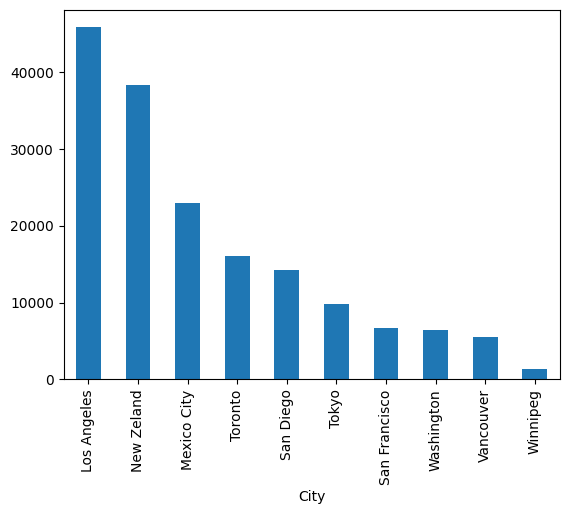

In [12]:
all_listings_non_Europe['City'].value_counts().plot(kind='bar')

Considering cities outside of Europe, this graph shows that Los Angeles has the most entries. This metropolis is one of the most important in the US and is an attractive destination for people from all over the world because of the Hollywood stars, shopping, culture and beaches. therefore, this spacious city offers many residences.

New Zealand ranks second, but it should be noted that this is a country and therefore there are more places available.Taking this into account, we noted that Mexico City has the second most entries within cities.

Looking at the cities outside of Europe, it can be said that there are the fewest entries in Washington and Vancouver, but the last place is Winnipeg in Canada

### **2.2) Price Analysis**

#### **Europe**

First of all, we decided to understand the prices data, because that variable will be crucial to achieve our revenue. In the graph below, it was plotted a Boxplot which we can see a distribution of the prices of each listining per city. On the graph, we can´t proprerly see the boxplot and the main values, because of the huge deviation caused by outliers.

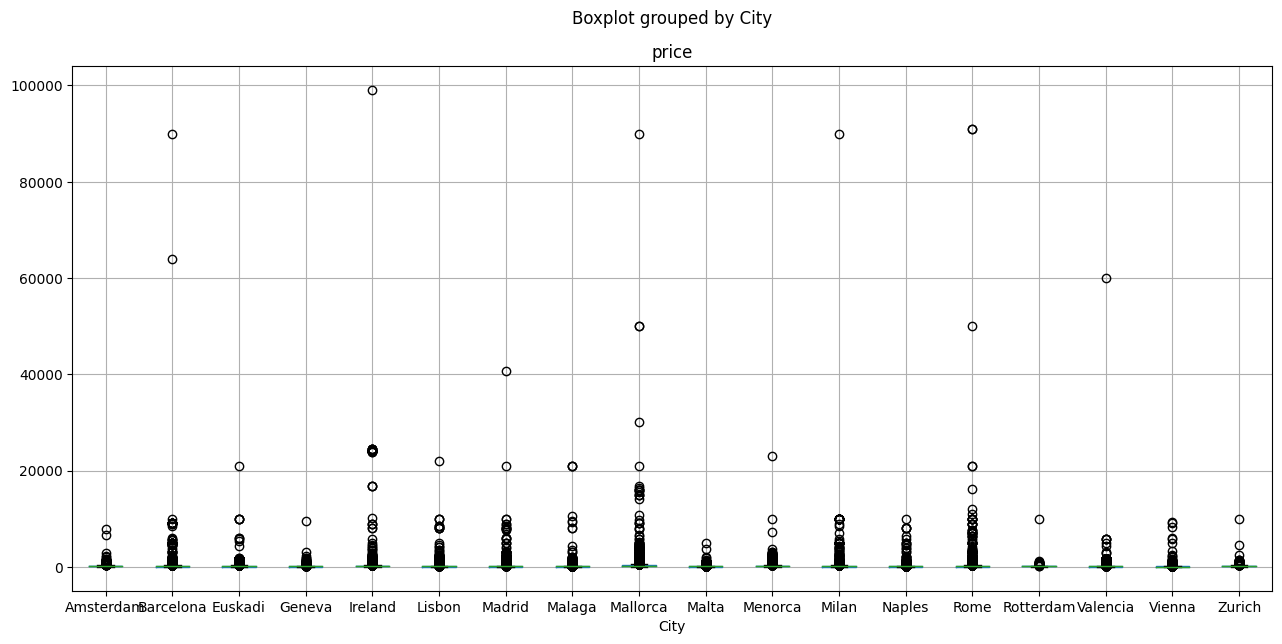

In [13]:
#Boxplot of the prices per City
_ = all_listings_Europe.boxplot(column="price", by="City", figsize=(15,7));

In [14]:
all_listings_Europe['price'].mean() + all_listings_Europe['price'].std() * 3

#removing listings with prices over 3 standard deviations above the mean
all_listings_Europe = all_listings_Europe[all_listings_Europe['price'] <= 2350];

In order to provide a better data understanding and integrity, we removed listings with prices over 3 standard deviations above the mean. As we know from statitics, 3 standard deviations above the mean is the 99.7 percentile. We are retaining all but the most extreme high values. These could be mega-mansions or possibly just errors or false listings. We decided to exclude these values as those values could inappropriately influence the remaining data trends.

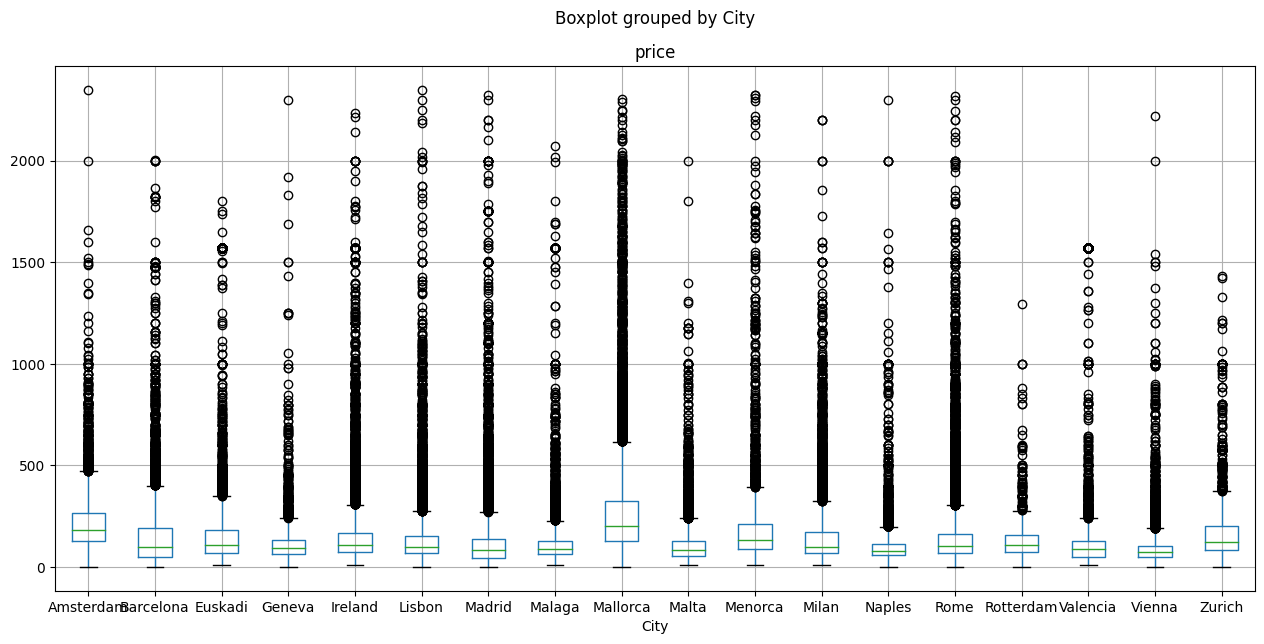

In [15]:
all_listings_Europe.boxplot(column="price", by="City", figsize=(15,7));

As we can now see, we no longer retain the values above $2350 per night. We are assuming that the investment needed to purchase a property that would go for above that nightly rate would be more than the scope of this investment opportunity.

In [16]:
#Average nightly price rating
Europe_Price_1 = all_listings_Europe.groupby('City')['price'].describe()
European_pp = Europe_Price_1
Europe_Price_1.sort_values(by = 'mean', ascending = False)

,count,mean,std,min,25%,50%,75%,max
City,,,,,,,,
Mallorca,18942.00,277.67,264.05,0.00,125.00,200.00,322.00,2303.00
Amsterdam,6890.00,216.07,147.08,0.00,125.00,180.00,263.00,2350.00
Menorca,3658.00,200.29,239.86,10.00,89.00,130.00,210.75,2321.00
Euskadi,6884.00,180.11,259.00,9.00,70.00,109.00,182.00,1800.00
Zurich,2243.00,179.47,174.31,0.00,83.00,120.00,199.00,1430.00
Ireland,25251.00,150.85,160.65,10.00,75.00,110.00,168.00,2233.00
Milan,19193.00,149.18,156.68,9.00,68.00,100.00,171.00,2200.00
Rome,24712.00,146.77,156.17,0.00,70.00,103.00,164.00,2320.00
Barcelona,16869.00,146.72,165.34,0.00,50.00,100.00,190.00,2004.00


This table shows the prices for each city and the given availabilities according to days booked in advance.

highest average nightly prices:
- Mallorca
- Amsterdam
- Menorca

lowest prices:
- Vienna
- Naples
- Malta


The overall European average nightly price is: € 152.07


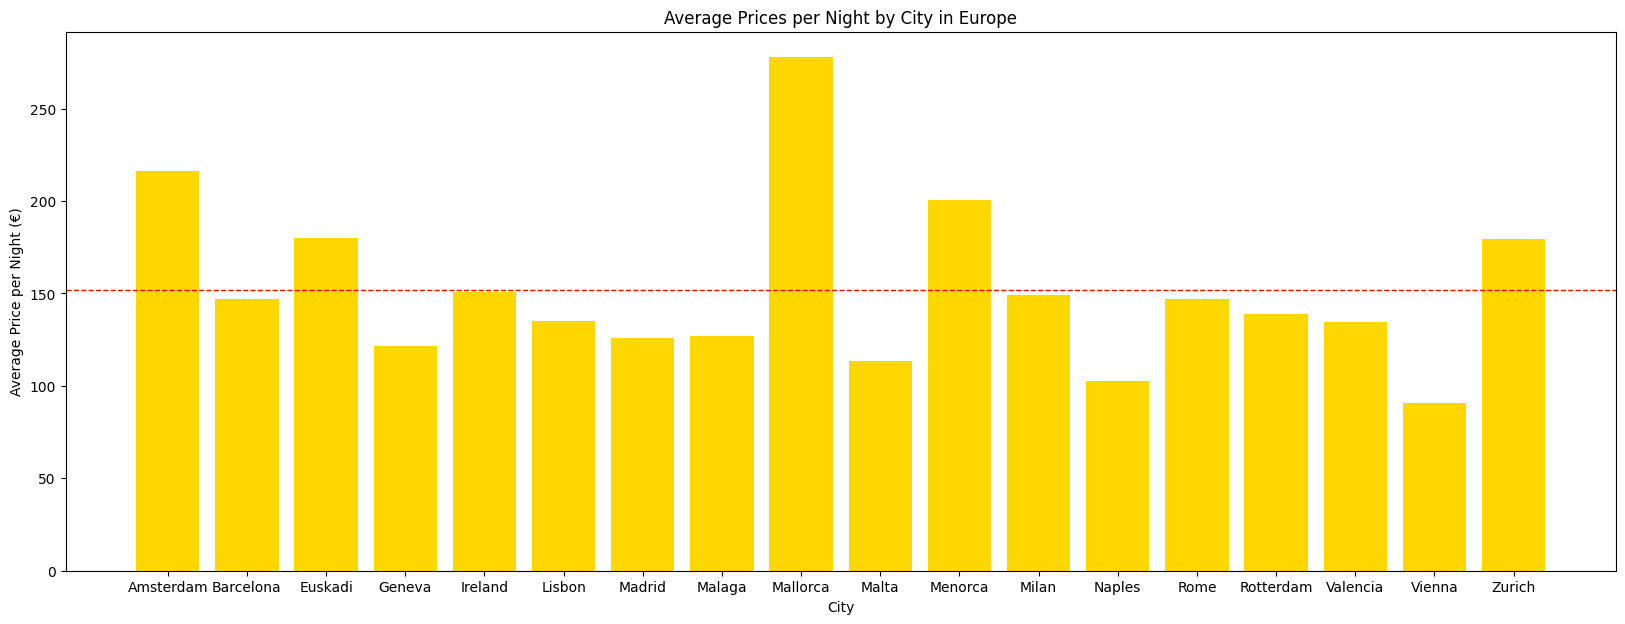

In [17]:
# Calculate the average nightly price by city in Europe
AvgPrice_Europe = pd.DataFrame(all_listings_Europe.groupby('City')['price'].mean().round(3))

# Calculate the overall average price across all European cities
AvgPrice_Europe_mean = AvgPrice_Europe['price'].mean()

# Plot the average prices per night by city
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(20, 7))
axs.bar(AvgPrice_Europe.index, AvgPrice_Europe['price'], color='gold')
axs.set_ylabel('Average Price per Night (€)')
axs.set_xlabel('City')
axs.set_title('Average Prices per Night by City in Europe')

# Add a horizontal line for the overall average price
axs.axhline(AvgPrice_Europe_mean, color='red', linestyle='--', linewidth=1)

# Print the overall European average nightly price
print('The overall European average nightly price is: €', AvgPrice_Europe_mean.round(2))

In the graph above, we visualized the average nightly rate for European cities. We see that Mallorca has the highest average price per night in Europe, followed by Amsterdam and Menora, previously mentioned.

Moreover, most of the cities are below the average price of Europe, which is $152.07 and only four cities surpass that threshhold, including Amsterdam, Euskadi (not a city but a region of Spain), Mallorca, Menorca and Zurich

Next, apart from where there were higher prices, we also wanted to see the distribution of them, for that we made the following density distribution graph:


<ipython-input-18-3e8d13096564>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(all_listings_Europe["price"], color="b")


<Axes: title={'center': 'Distribution of Prices Europe'}, xlabel='price', ylabel='Density'>

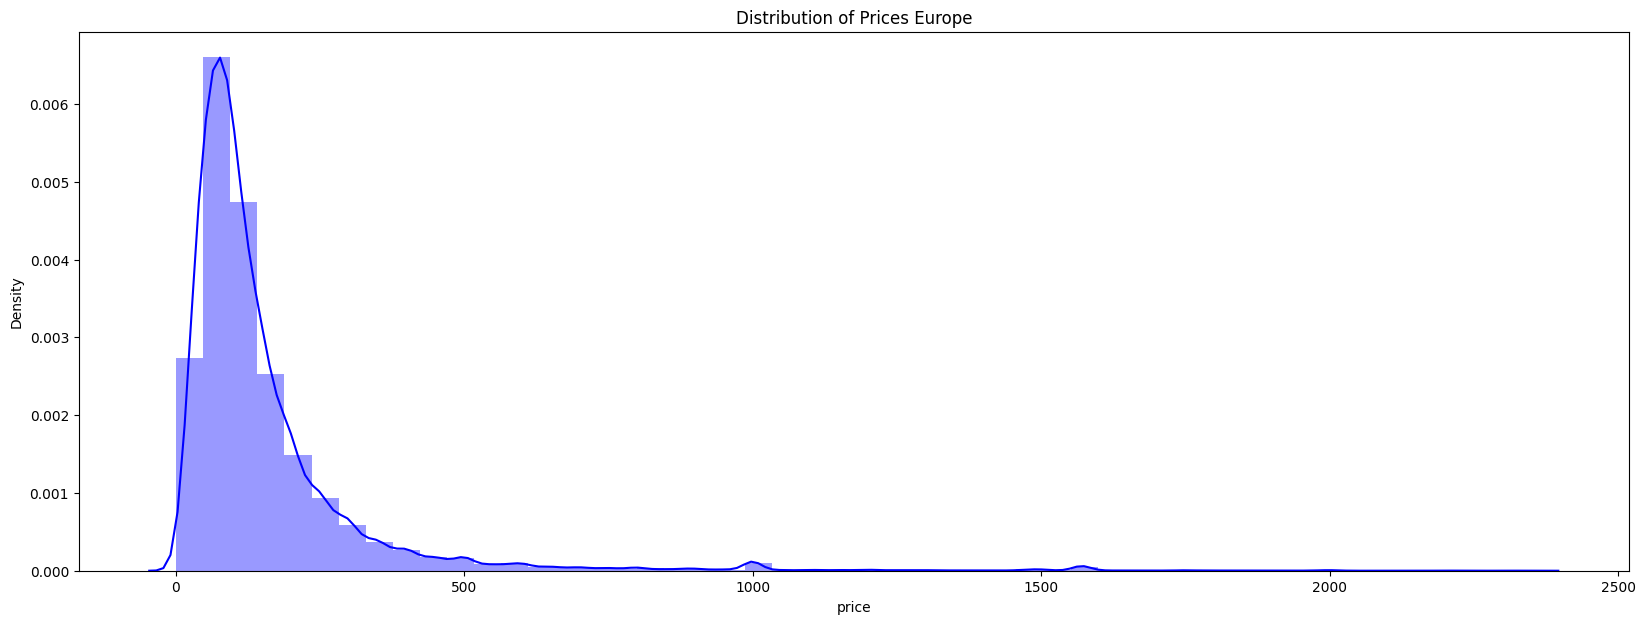

In [18]:
plt.figure(figsize=(20,7))
plt.title("Distribution of Prices Europe")
sns.distplot(all_listings_Europe["price"], color="b")

Most of the prices are concentrated between 0 and 500, which is a very large range but it can be also seen that there are even some prices reaching 1000 and even 1500, this could be due to the existence of high end appartments.

**Average Price per Country**

In the Choropleth map below, we can see the European countries highlighted on the map and the average price per night of each country


In [19]:
# Add ISO country codes to the average price DataFrame
AvgPrice_Europe['country'] = [
    'NLD', 'ESP', 'ESP', 'ITA', 'IRL', 'PRT', 'ESP', 'ESP', 'ESP', 'MLT',
    'ESP', 'ITA', 'ITA', 'ITA', 'NLD', 'ESP', 'AUT', 'CHE'
]

# Calculate the average price per country
dfa = pd.DataFrame(AvgPrice_Europe.groupby('country')['price'].mean().round(3))

# Prepare the data for the choropleth plot
grafico = pd.DataFrame()
grafico['price'] = dfa['price']
grafico['country'] = ['AUT', 'CHE', 'ESP', 'IRL', 'ITA', 'MLT', 'NLD', 'PRT']

# Create the choropleth plot
fig = px.choropleth(
    grafico,
    locations='country',
    color='price',
    hover_name='country',
    color_continuous_scale=px.colors.sequential.Plasma
)

# Show the plot
fig.show()

With this map we can easily visually identify which are the most and least expensive cites in Europe, the highest overall are Switzerland, the Netherlands and Spain and Austria and Italy are more affordable.

#### **Non-Europe**

For the Non-european data sets we went through the same cleaning and analytical process that we just completed for the European market.

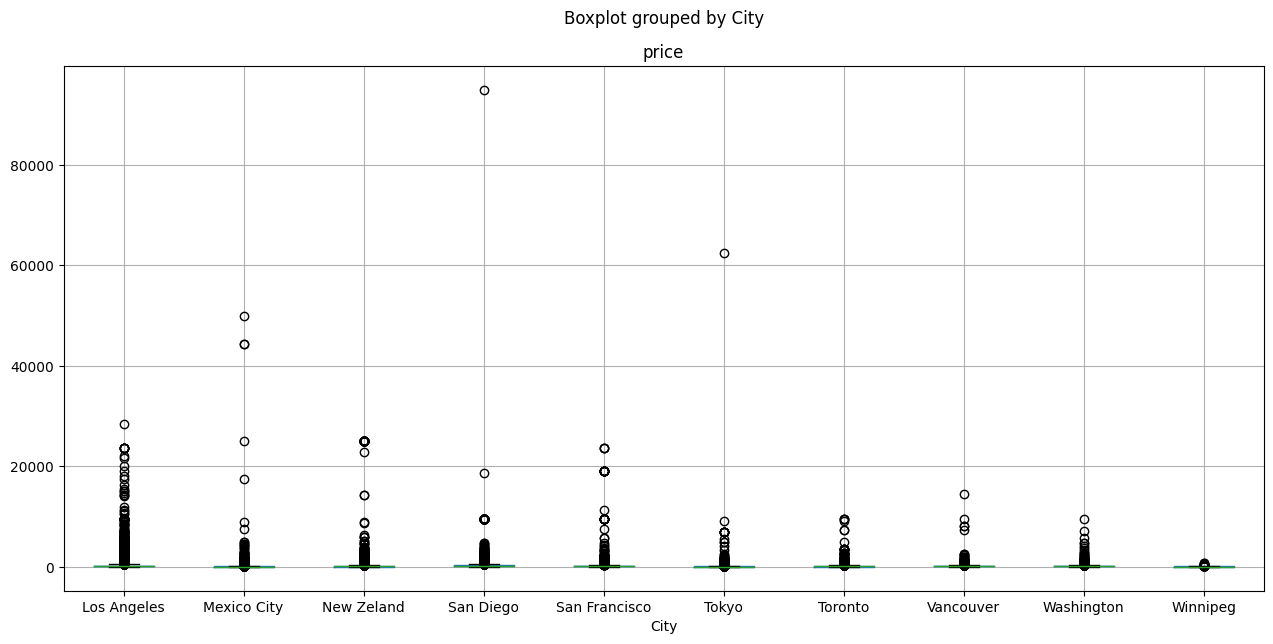

In [20]:
#Boxplot of the prices per City
_=all_listings_non_Europe.boxplot(column="price", by="City", figsize=(15,7))

In [21]:
all_listings_non_Europe['price'].mean() + all_listings_non_Europe['price'].std() * 3

#removing listings with prices over 3 standard deviations above the mean
all_listings_non_Europe = all_listings_non_Europe[all_listings_non_Europe['price'] <= 2570]

Once again, we will remove listings 3 or more standard deviations above the mean in nightly price to eliminate possible 'red-hearings' in the data

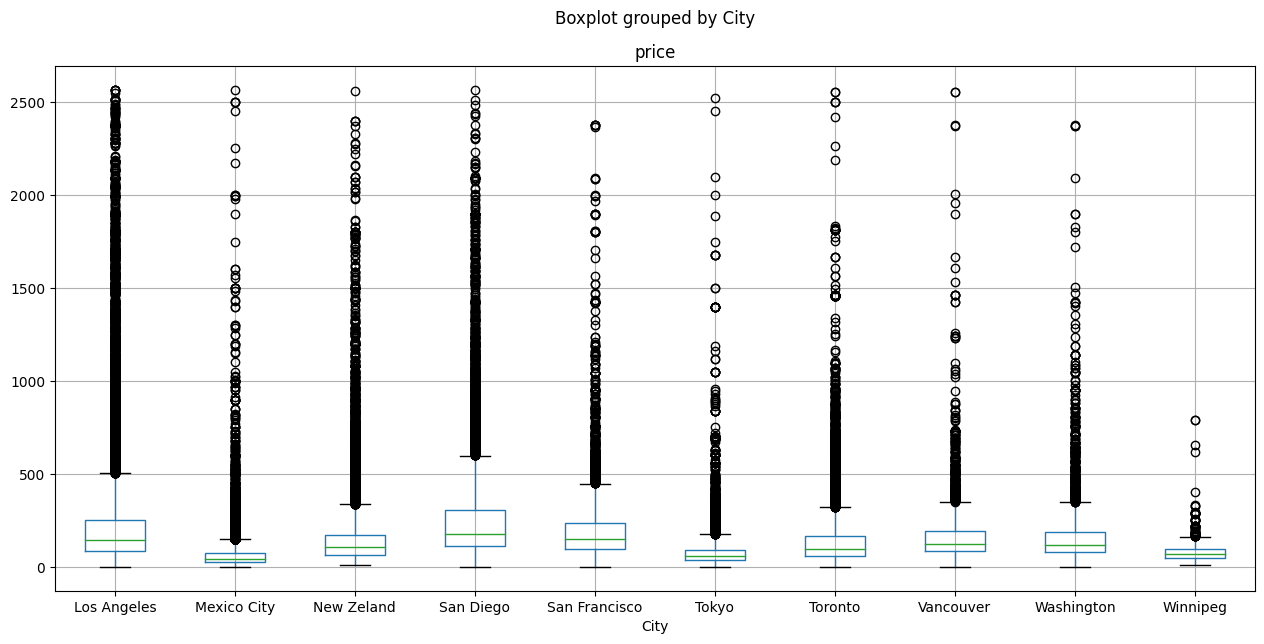

In [22]:
all_listings_non_Europe.boxplot(column="price", by="City", figsize=(15,7));

As you can see, many of the cities have outliers reaching the upperbounds, but what we are more focused on is the middle 50%, it appears that the Californian cities have the highest average nightly price.

After examining the price, we examine the ratings for cities outside of Europe

In [23]:
#Average nightly price rating
Non_Europe_Price_1 = all_listings_non_Europe.groupby('City')['price'].describe()
Non_European_pp = Non_Europe_Price_1
Non_Europe_Price_1.sort_values(by = 'mean', ascending = False)

,count,mean,std,min,25%,50%,75%,max
City,,,,,,,,
San Diego,14081.00,264.14,273.86,0.00,111.15,176.70,305.90,2564.05
Los Angeles,45411.00,228.78,277.70,0.00,85.50,142.50,252.70,2565.00
San Francisco,6584.00,208.29,204.08,0.00,96.90,149.15,237.50,2375.95
Washington,6462.00,162.45,158.58,0.00,81.70,118.75,189.05,2375.00
Vancouver,5567.00,161.97,151.18,0.00,83.95,123.37,190.53,2555.00
New Zeland,38227.00,148.23,155.13,8.40,66.00,107.40,174.00,2559.00
Toronto,16015.00,143.82,167.28,0.00,58.40,94.90,164.25,2555.00
Tokyo,9809.00,90.41,130.98,0.00,36.40,56.00,93.00,2520.00
Winnipeg,1339.00,78.75,56.64,11.68,47.45,69.35,93.44,792.05


This table shows the prices for each city and the given availabilities according to days booked in advance.

highest prices:
- San Diego
- San Francisco
- Los Angeles

lowest prices:
- Tokyo
- Winnipeg
- Mexico City

The overall average price per night is 167.677€.

The overall non-European average nightly price is: € 155.28


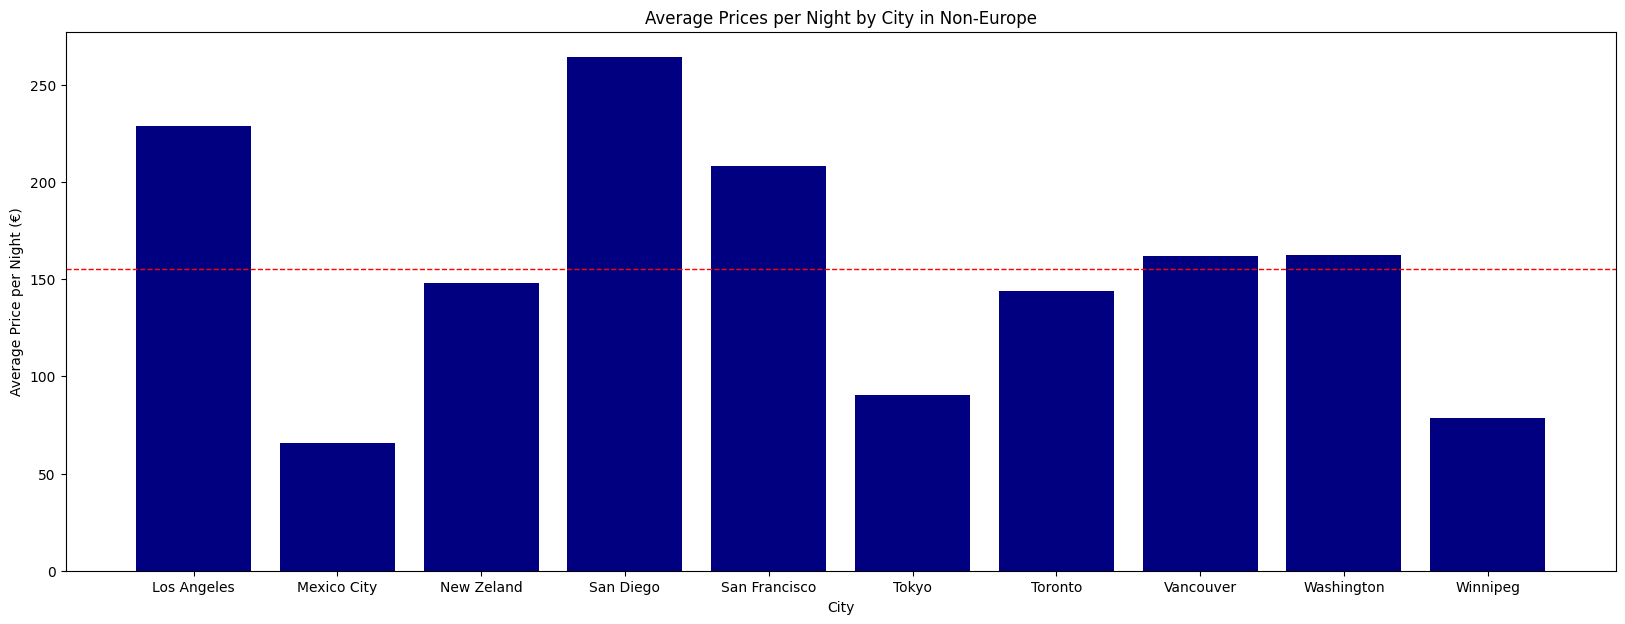

In [24]:
# Calculate the average nightly price by city in non-European listings
AvgPrice_non_Europe = pd.DataFrame(all_listings_non_Europe.groupby('City')['price'].mean().round(3))

# Calculate the overall average price for non-European cities
AvgPrice_non_Europe_mean = AvgPrice_non_Europe["price"].mean()

# Plot the average prices per night by city
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(20, 7))
axs.bar(AvgPrice_non_Europe.index, AvgPrice_non_Europe['price'], color='navy')
axs.set_ylabel('Average Price per Night (€)')
axs.set_xlabel('City')
axs.set_title('Average Prices per Night by City in Non-Europe')

# Add a horizontal line for the overall average price
axs.axhline(AvgPrice_non_Europe_mean, color='red', linestyle='--', linewidth=1)

# Print the overall non-European average nightly price
print('The overall non-European average nightly price is: €', AvgPrice_non_Europe_mean.round(2))

In the previous graph it can be seen that there are three outstanding cities: San Diego, Los Angeles and San Francisco. New Zealand is the only other 'city' over the average but it is an interesting case as it a small country not a single city.

On the other hand, Mexico City and Winnipeg have noticeable lower prices, being the cheaper ones of the list, Tokyo.

Next, we will examine the density distribution of the price data.

<ipython-input-25-f124db8a8454>:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




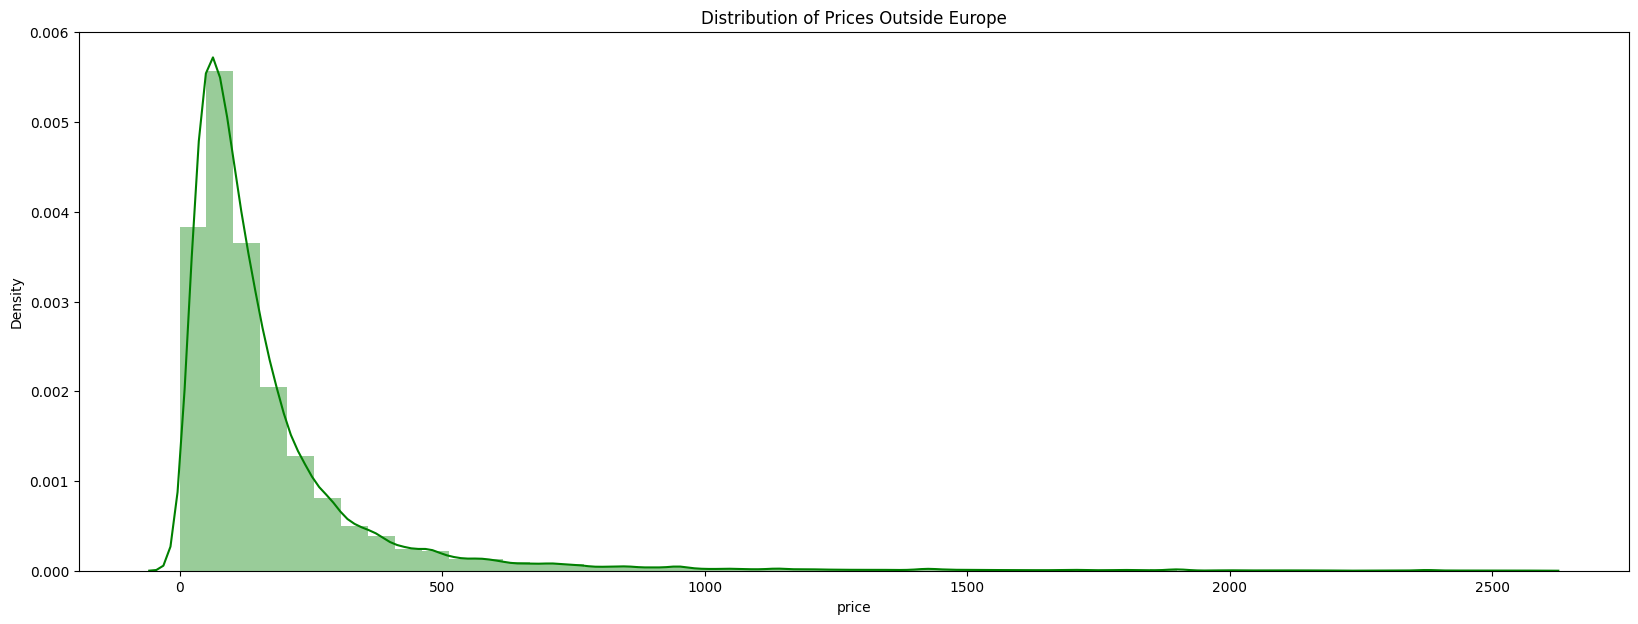

In [25]:
plt.figure(figsize=(20,7));
plt.title("Distribution of Prices Outside Europe");
sns.distplot(all_listings_non_Europe["price"], color="g");

Most of the prices are concentrated between 0 and 500, which is a very large range but it can be also seen that there are even some prices reaching 1000 and even 2500, this could be due to the existence of high end properties such as beach mansions and high end apartments.

**Average Price per Country**

In [26]:
# Assign ISO country codes to the non-European average price DataFrame
AvgPrice_non_Europe['country'] = ['USA', 'MEX', 'NZL', 'USA', 'USA', 'JPN', 'CAN', 'CAN', 'USA', 'CAN']

# Calculate the average price per country
dfa = pd.DataFrame(AvgPrice_non_Europe.groupby('country')['price'].mean().round(3))

# Prepare the data for the choropleth plot
grafico = pd.DataFrame()
grafico['price'] = dfa['price']
grafico['country'] = ['CAN', 'JPN', 'MEX', 'NZL', 'USA']

# Create the choropleth plot
fig = px.choropleth(
    grafico,
    locations='country',
    color='price',
    hover_name='country',
    color_continuous_scale=px.colors.sequential.Plasma
)

# Show the plot
fig.show()

We have visualized the overall mean for each country we have data on. We can see that the US is by far the brightest.

### **2.3) Correlation Analysis**

#### **Europe**

Text(0.5, 1.0, 'Correlation matrix of Europe´s listings')

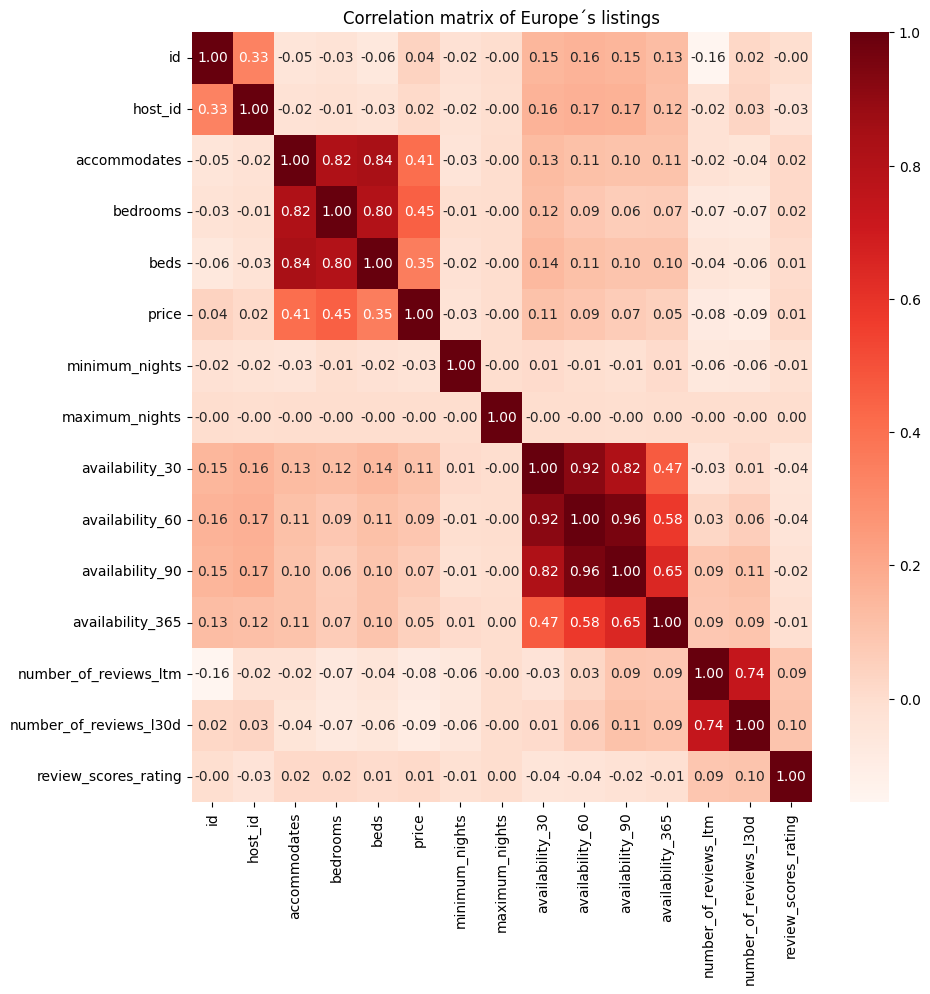

In [27]:
f,ax= plt.subplots(figsize=(10,10))

# Select only numeric columns for correlation calculation
numeric_df = all_listings_Europe.select_dtypes(include=['number'])
sns.heatmap(numeric_df.corr(),annot=True, cmap='Reds', fmt='.2f', ax=ax)

plt.title("Correlation matrix of Europe´s listings")

From this correlation heat map, we dont see strong correlation between most of the variables. Notable exceptions include strong relationships between accomadation, beds, bedrooms and price. Also, there is strong correlation between the availabilty, 30, 60, 90 and 365 days out.

#### **Non-Europe**

Text(0.5, 1.0, 'Correlation matrix of Non-Europe´s listings')

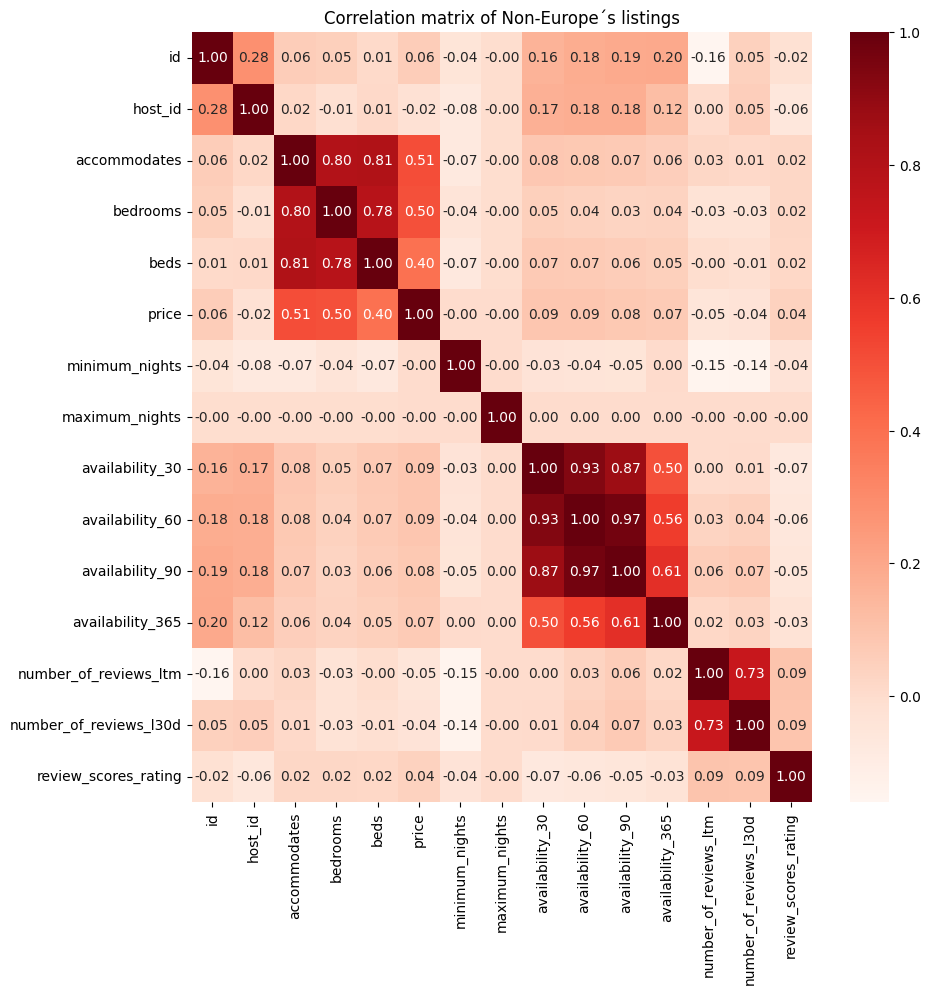

In [28]:
f,ax= plt.subplots(figsize=(10,10))

# Select only numeric columns for correlation calculation
numeric_df = all_listings_non_Europe.select_dtypes(include=['number'])

sns.heatmap(numeric_df.corr(),annot=True, cmap='Reds', fmt='.2f', ax=ax)
plt.title("Correlation matrix of Non-Europe´s listings")

Here, much like the European data, this correlation heat map, doesn't show a strong correlation between most of the variables. Notable exceptions include strong relationships between accomadation, beds, bedrooms and price. Also, there is strong correlation between the availabilty, 30, 60, 90 and 365 days out.

### **2.4) Analysis of Reviews**

#### **Europe**

We will now examine the rating data for these listings.

In [29]:
#Average review scores rating
Europe_RSR = all_listings_Europe.groupby('City')['review_scores_rating'].describe()
Europe_RSR.sort_values(by = 'mean', ascending = False)

,count,mean,std,min,25%,50%,75%,max
City,,,,,,,,
Amsterdam,6245.00,4.81,0.29,0.00,4.75,4.89,5.00,5.00
Ireland,22563.00,4.77,0.50,0.00,4.75,4.90,5.00,5.00
Zurich,1800.00,4.72,0.53,0.00,4.65,4.86,5.00,5.00
Rotterdam,909.00,4.70,0.43,0.00,4.62,4.82,4.95,5.00
Euskadi,5832.00,4.69,0.46,0.00,4.60,4.80,4.94,5.00
Rome,21028.00,4.67,0.52,0.00,4.60,4.80,4.93,5.00
Vienna,9862.00,4.67,0.60,0.00,4.61,4.83,5.00,5.00
Geneva,2787.00,4.67,0.54,0.00,4.56,4.81,5.00,5.00
Naples,6190.00,4.67,0.55,0.00,4.60,4.82,4.97,5.00


The city with the highest average rating is Amsterdam, the next highest are Ireland and Zurich. The lowest rated cities are all Spanish, including Barcelona, Madrid and Valencia.. However the difference between the highest and lowest average rating is only 0.3 stars.

<Axes: xlabel='City', ylabel='review_scores_rating'>

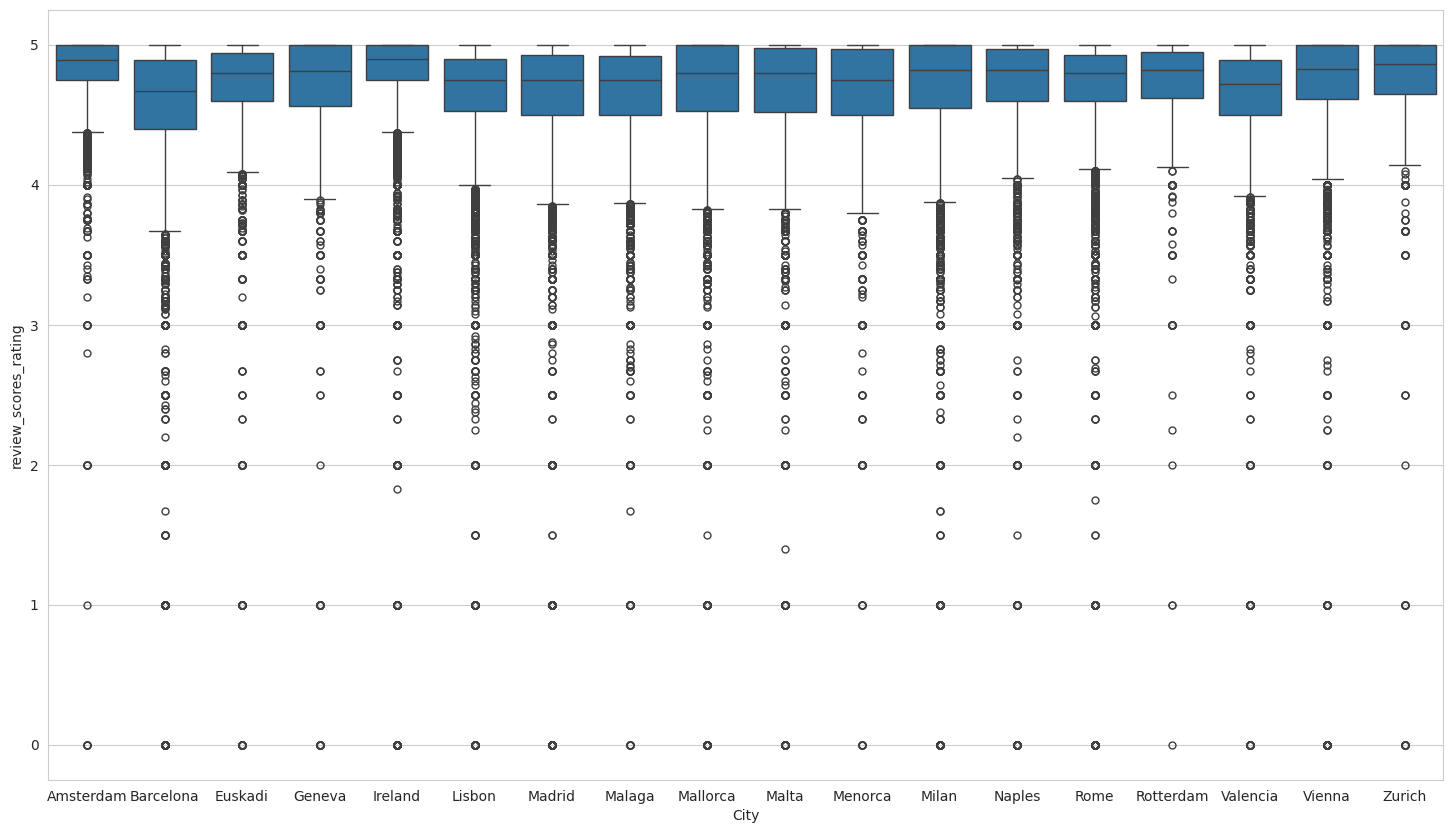

In [30]:
#Boxplot of the reviews per City
plt.figure(figsize=(18,10))

sns.set_style("whitegrid")
sns.boxplot(x = 'City', y = 'review_scores_rating', data = all_listings_Europe,
            saturation=0.75, width=.8, fliersize=5, whis=1.5)

These boxplots are representative of the reviews for each city. As you can see, the majority of all reviews are above 4.5 stars, however you can see there are many many outliers. All cities have ratings of all values but as you can see cities such as Amsterdam and Zurich have their distributions right up to the maximum.

#### **Non-Europe**

We will now examine the rating data for these non-european listings.

In [31]:
#Average review scores rating
Non_Europe_RSR = all_listings_non_Europe.groupby('City')['review_scores_rating'].describe()
Non_Europe_RSR.sort_values(by = 'mean', ascending = False)

,count,mean,std,min,25%,50%,75%,max
City,,,,,,,,
New Zeland,33415.00,4.79,0.42,0.00,4.75,4.89,4.99,5.00
Vancouver,4760.00,4.75,0.44,0.00,4.70,4.86,5.00,5.00
San Diego,12428.00,4.75,0.41,0.00,4.68,4.86,4.97,5.00
San Francisco,5507.00,4.75,0.49,0.00,4.71,4.89,5.00,5.00
Washington,5291.00,4.72,0.49,0.00,4.67,4.85,4.96,5.00
Winnipeg,1163.00,4.72,0.50,0.00,4.67,4.83,4.96,5.00
Mexico City,18871.00,4.70,0.58,0.00,4.67,4.85,5.00,5.00
Los Angeles,35098.00,4.70,0.61,0.00,4.67,4.88,5.00,5.00
Toronto,12630.00,4.68,0.65,0.00,4.65,4.85,5.00,5.00


 The city with the highest average rating is New Zealand, the next highest are Vancouver and San Diego. The lowest rated cities are Tokyo, Toronto and Los Angeles. Notably the difference between the highest and lowest average rating is only 0.13 stars.

<Axes: xlabel='City', ylabel='review_scores_rating'>

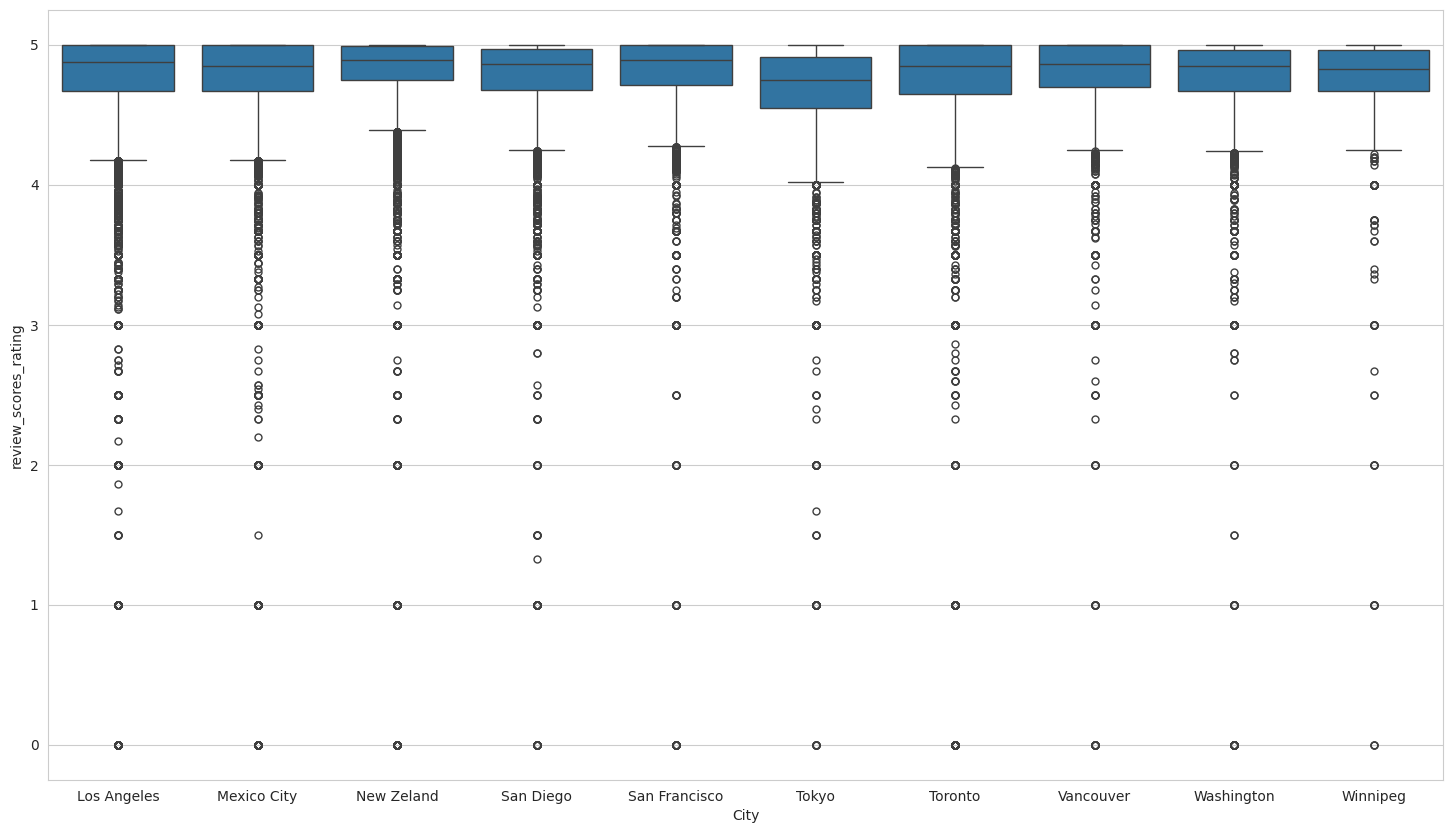

In [32]:
#Boxplot of the reviews per City
plt.figure(figsize=(18,10))

sns.set_style("whitegrid")
sns.boxplot(x = 'City', y = 'review_scores_rating', data = all_listings_non_Europe,
            saturation=0.75, width=0.8, fliersize=5, whis=1.5)

In comparison to the European cities, the Non-Euro cities are much closer to eachother in average rating. However, Tokyo is notably lower in average rating that its neighbors on the graph.

### **2.5) Summary**

First we loaded all the data sets from different cities around the world, after that we prepared them for the data analysis. For doing that, we created a European and Non-Europea dataset to make them more comparable.
For data cleaning, we removed columuns which only consisted of NAs, for example the bathroom column. But we decided to reformat some of the columns, by converting them from string to datatime format.
One important factor also arises with regard to the currency: We adjusted the different respective national currency with the exchange rates to EUR €. This enables us to compare the prices from Switzeeland, USA, Japan etc. more easily.

Secondly, we did an explorative data analysis for European as well as for Non-European cities separately to get better insights about the data sets.

**European Cities:**

From all the observed cities in Europe we can see that in Ireland are most entries, but we should not neglect that Ireland is a whole country, so it´s obvious that there are more entries. If we only consider cities, the most entries can be found in Rome, followed by Madrid. The least entries are offered in Rotterdam and Zurich. One possible reason for that could that some cities are more touristic and attractive for people going on holidays, maybe als due to different climate zones.



By doing some visualisation, we realized that there are some outliers concerning the prices. For example, in Ireland and Barcelona are some upper outliers, because of luxury aparments and famous touristic places.
The overall average price is 152.991€ in European cities. Through the distribution graph we earned the information that the average prices are between 100 and 220 in European cities.
Some graphs can show the previously estimated average prices; it can be seen that Mallorca has the higher average prices, which aligns with the outliers there owing to high-end apartments; this could be a factor that influences the average of all the apartments in Mallorca.
The heatmap could not give us anwers about the correlation of the prices, which we actually expected to get. But we found some correlations between availability in 30, 60, 90 and 365 days
and also between accomodates, beds and bathrooms.

Our analysis does not only focus on prices, but we also wanted to take a closer look at customer satisfaction. Airbnb offers a ranking between 1 and 5 stars. Overall, we can say that the ratings were generally good, mostly above 4 stars. The most satisfied were those who stayed in Amsterdam with 4.81 starts, the least satisfied were those who spent their stay in in Madrid, with 4.59 stars.

For the revenue of the cities, we first considered two varables: price and availability, with it we will get the expected income.

We calculated the revenue by multiplying price by days booked. By doing visualisations, we found out that the estimated revenues based on 365-day availability information differs from predicting revenues for the entire year if we assume that the 30-day availability persists. This demonstrates that several cities, mostly Menorca and Euskadi, have ann increase in annual revenue predictions when adopting the 30day technique.

**Non-European Cities**

Los Angeles has the most entries when it comes to cities outside of Europe. Being one of the most significant cities in the US, it is a desirable place to live as well as visit.
The second-placed is New Zealand, but it should be emphasized that there are more apartments available because it is a whole country.
In context of this, we observed that Mexico City has the second-highest number of entries among cities.
When looking at cities outside of Europe, Washington and Vancouver have only a few entries, while Winnipeg in Canada, comes in last.

For the price analysis we found that that there are some outliers, as well as an Europe, because of high-end apartments in San Diego, Los Angeles and San Francisco. The overall average price is in 167,677 - therefore higher than in European cities. The highest prices are in San Diego, LA and SF, the lowest prices outside of Europe could be found in Tokyo, Winnipeg and Mexico City. The price distribution among cities outside of Europe is between 80 and 320, so there is a wider range than in European cities. Unfortunately, there is also no clear correlation between the price and another feature in the heatmap of non-europlan cities. Nevertheless, there exists a high correlation between the availability in 30, 60, 90 and 365 days, but between accomodates, bedrooms and beds as well.

We did not neglect customer reviews for cities outside of Europe, and here, too, we found a high level of satisfaction among the customers. The best ratings were for flats in New Zealand (4.78) and Vancouver (4.75), the worst for Tokyo (4.65) and Toronto (4.68) - however all received over 4 stars.



#**3) Revenue Analysis + Profitability Esimtation + Investment Advice**

Next we focus on analyzing the revenue that is driven by properties in the different cities while also considering some characteristics of these properties. Additionally we will invoke an estimate for the costs that are associated with purchasing a place to estimate in which cities to best invest and to invest into what kind of properties.

### **3.1) Revenue Calculation**


Before we however analyze the revenue and later profits we need to generate the revenue variable per listing. This we do as follows. We take from the availability variable the information how many days a place is available the coming x (30, 60, 90, 365) days. This we use to infer how many days it is booked and multiply this number of available days with the price for the listing per night. This way we obtain the expected revenue for a listing for the next x days. Note crucially that we here make the assumption that the price for a listing per night is fixed indepenent of the number of visitors.

In [33]:
# calculate expected revenue x (30/60/90/365) days out


# append all_listings_Europe by columns with number of booked nights x (30/60/90/365) days out
all_listings_Europe['days_booked_30'] = 30 - all_listings_Europe['availability_30']
all_listings_Europe['days_booked_60'] = 60 - all_listings_Europe['availability_60']
all_listings_Europe['days_booked_90'] = 90 - all_listings_Europe['availability_90']
all_listings_Europe['days_booked_365'] = 365 - all_listings_Europe['availability_365']

# append all_listings_Europe by columns with expected revenue x (30/60/90/365) days out
all_listings_Europe['exp_rev_30'] = all_listings_Europe['price'] * all_listings_Europe['days_booked_30']
all_listings_Europe['exp_rev_60'] = all_listings_Europe['price'] * all_listings_Europe['days_booked_60']
all_listings_Europe['exp_rev_90'] = all_listings_Europe['price'] * all_listings_Europe['days_booked_90']
all_listings_Europe['exp_rev_365'] = all_listings_Europe['price'] * all_listings_Europe['days_booked_365']

# append all_listings_non_Europe by columns with number of booked nights x (30/60/90/365) days out
all_listings_non_Europe['days_booked_30'] = 30 - all_listings_non_Europe['availability_30']
all_listings_non_Europe['days_booked_60'] = 60 - all_listings_non_Europe['availability_60']
all_listings_non_Europe['days_booked_90'] = 90 - all_listings_non_Europe['availability_90']
all_listings_non_Europe['days_booked_365'] = 365 - all_listings_non_Europe['availability_365']

# append all_listings_non_Europe by columns with expected revenue x (30/60/90/365) days out
all_listings_non_Europe['exp_rev_30'] = all_listings_non_Europe['price'] * all_listings_non_Europe['days_booked_30']
all_listings_non_Europe['exp_rev_60'] = all_listings_non_Europe['price'] * all_listings_non_Europe['days_booked_60']
all_listings_non_Europe['exp_rev_90'] = all_listings_non_Europe['price'] * all_listings_non_Europe['days_booked_90']
all_listings_non_Europe['exp_rev_365'] = all_listings_non_Europe['price'] * all_listings_non_Europe['days_booked_365']

Next we investigate the correlations between the expected revenues for 30, 60, 90 and 365 days out, for the european cities and non-european cities seperately.

In [34]:
# Correlation of expected revenue in Europe
corr_exp_rev_EUR = {
    'exp_rev_30': all_listings_Europe['exp_rev_30'],
    'exp_rev_60': all_listings_Europe['exp_rev_60'],
    'exp_rev_90': all_listings_Europe['exp_rev_90'],
    'exp_rev_365': all_listings_Europe['exp_rev_365']
}

# Create a DataFrame for the expected revenue data
corr_exp_rev_EUR_df = pd.DataFrame(corr_exp_rev_EUR)

# Calculate and display the correlation matrix
corr_exp_rev_EUR_df.corr()


,exp_rev_30,exp_rev_60,exp_rev_90,exp_rev_365
exp_rev_30,1.00,0.98,0.95,0.83
exp_rev_60,0.98,1.00,0.99,0.86
exp_rev_90,0.95,0.99,1.00,0.88
exp_rev_365,0.83,0.86,0.88,1.00


In [35]:
# Correlation of expected revenue in non-European listings
corr_exp_rev_non_EUR = {
    'exp_rev_30': all_listings_non_Europe['exp_rev_30'],
    'exp_rev_60': all_listings_non_Europe['exp_rev_60'],
    'exp_rev_90': all_listings_non_Europe['exp_rev_90'],
    'exp_rev_365': all_listings_non_Europe['exp_rev_365']
}

# Create a DataFrame for the expected revenue data
corr_exp_rev_non_EUR_df = pd.DataFrame(corr_exp_rev_non_EUR)

# Calculate and display the correlation matrix
corr_exp_rev_non_EUR_df.corr()

,exp_rev_30,exp_rev_60,exp_rev_90,exp_rev_365
exp_rev_30,1.00,0.97,0.94,0.76
exp_rev_60,0.97,1.00,0.99,0.78
exp_rev_90,0.94,0.99,1.00,0.80
exp_rev_365,0.76,0.78,0.80,1.00


Since we can see that there are very high positive correlations between the expected revenues for the different number of days out (indicating a high degree of linear comovement) we decide to proceed only with the 30 days out expected revenue to keep the analysis concise and since we can see that a very similar trend can be observed between the different revenue horizons.

### **3.2) Revenue Analysis**

**Europe**

Since we now have data on the expected revenues of the listing we start by performing some basic descriptive statistics per city to get a first feel for the expected profits per city.

In [36]:
all_listings_Europe.groupby('City')['exp_rev_30'].describe().sort_values('mean', ascending = False)

,count,mean,std,min,25%,50%,75%,max
City,,,,,,,,
Amsterdam,6890.00,5536.12,3761.58,0.00,3150.00,4620.00,6870.00,70500.00
Mallorca,18942.00,5390.37,6786.88,0.00,1360.00,3519.50,6500.00,67500.00
Zurich,2243.00,3878.83,4268.43,0.00,1680.00,2670.00,4350.00,34020.00
Rome,24712.00,3479.27,3631.17,0.00,1650.00,2610.00,4080.00,64260.00
Milan,19193.00,3188.96,3778.93,0.00,1440.00,2200.00,3584.00,66000.00
Euskadi,6884.00,3172.69,7502.65,0.00,440.00,1386.00,2900.00,47100.00
Valencia,7345.00,3066.79,6953.39,0.00,840.00,1786.00,2790.00,47100.00
Menorca,3658.00,2969.14,5362.40,0.00,324.00,1500.00,3388.00,63720.00
Rotterdam,1041.00,2922.26,2370.74,0.00,1508.00,2400.00,3600.00,20280.00


To illustrate this result further we plot the average expected revenues per city in the next plot.

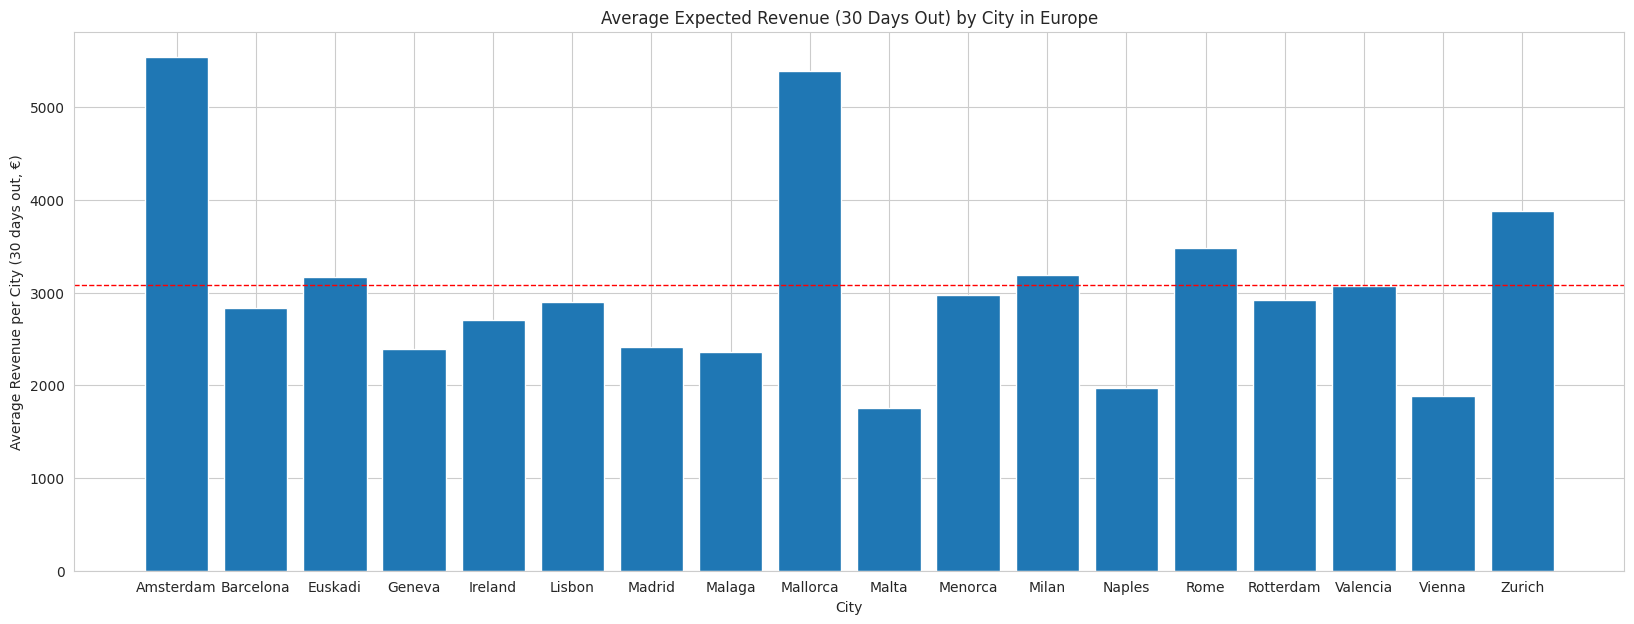

In [37]:
# Calculate the average expected revenue (30 days out) by city in Europe
Avg_Rev_EUR_30 = all_listings_Europe.groupby('City')['exp_rev_30'].mean().round(3).reset_index()

# Plot the average expected revenue for each city
fig, ax = plt.subplots(figsize=(20, 7))
ax.bar(Avg_Rev_EUR_30['City'], Avg_Rev_EUR_30['exp_rev_30'])
ax.set_ylabel('Average Revenue per City (30 days out, €)')
ax.set_xlabel('City')
ax.set_title('Average Expected Revenue (30 Days Out) by City in Europe')

# Add a horizontal line for the overall average revenue
overall_avg_revenue = all_listings_Europe['exp_rev_30'].mean().round(3)
ax.axhline(overall_avg_revenue, color='red', linestyle='--', linewidth=1)

plt.show()

Based on this it seems (without any further analysis) that the expected revenue for airbnbs seems to be particularly high in cities such as Amsterdam and Mallorca. This has to however be taken with a grain of salt. The reason for this is that we mearely observe correlations, i.e. we just happen to observe that e.g. the revenue of airbnbs in Amsterdam is particularly high compared to other cities, this could however e.g. be caused by the fact that the airbnbs in Amsterdam are all disproportionaltly large and hence more expensive. To investigate causal relationships we hence need to proceed differently to isolate the city specific impact on the revenue and the impact of factors such as how many bedrooms an airbnb has. For this we perform a regression analysis.

To perform the regression analysis we do however have to perform some steps, these are explained in the code.

In [38]:
# Setting up data for running regression

# Variables are chosen based on economic intuition to explain variation without making the model overly complex.
# Categorical variables with too many categories are excluded to avoid excessive dummy variables.

# Select data for regression
reg_data_Europe = all_listings_Europe[['exp_rev_30', 'room_type', 'accommodates',
                                       'bedrooms', 'beds', 'price', 'minimum_nights', 'City']]

# Preprocess data for regression

# Drop rows with missing values to avoid potential bias from imputation
reg_data_Europe = reg_data_Europe.dropna().reset_index(drop=True)

# Target variable
reg_data_Europe_y = reg_data_Europe['exp_rev_30']

# Dummy encode categorical variables ('room_type' and 'City'), omitting the first category to avoid multicollinearity
reg_data_Europe_X_transform = pd.get_dummies(reg_data_Europe[['room_type', 'City']], drop_first=True)

# Select numerical variables
reg_data_Europe_X_not_transform = reg_data_Europe[['accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights']]

# Merge transformed and numerical variables
reg_data_Europe_X = pd.concat([reg_data_Europe_X_not_transform, reg_data_Europe_X_transform], axis=1)

# Replace True/False with 1/0 for regression
reg_data_Europe_X = reg_data_Europe_X.replace({True: 1, False: 0})

# Add constant to predictor variables for the regression model
reg_data_Europe_X = sm.add_constant(reg_data_Europe_X)

# Fit linear regression model
model_EUR = sm.OLS(reg_data_Europe_y, reg_data_Europe_X).fit()

# Display model summary
print(model_EUR.summary())


                            OLS Regression Results                            
Dep. Variable:             exp_rev_30   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                 1.185e+04
Date:                Thu, 19 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:35:17   Log-Likelihood:            -1.8474e+06
No. Observations:              199844   AIC:                         3.695e+06
Df Residuals:                  199818   BIC:                         3.695e+06
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   1989

Now that we have run the regression we can isolate the specific effects of the regressors on the dependent variable, i.e. we can now talk about how the indiviual components explain the expected revenue.

Interpretation some interesting regression results:

- firstly note that the model significantly improves upon the constant only model (see F-statistic)
- next interestingly notice that all coefficients of the regression are highly statistically significant
- an increase in accomodates and bedrooms are associated with an increase in expected revenue, although the magnitude of bedrooms is substantially larger, this can most likely be explained by the fact that bedrooms falls victim to omitted variable bias since we have no data on the size of the place (more bedrooms usually indicate a larger place)
- it yields a higher expected return to rent out the entire place which we can find by the coefficients of the room_type varibles which are all negative which suggests that any of the three listed alternatives decreases the expected revenue compared to renting out the entire place (the omitted category for room_types to avoid into issues of multicollinearity)
- most importantly the coefficients of the city-dummies indicate the city specific impact on revenue by a specific city compared to Amsterdam (the omitted category), we can immediately see that the city specifc contribution to revenue is highest in Amsterdam since all coefficient on the other city-dummies are negative, from this we could conclude that is is recommend to invest in amsterdam to benefit of the city-specific benefit on revenue

NOTE: We will utilize the city-dummy coefficients later more (see Profitability Estimation + Investment Advice)

**non-Europe**

We will follow the same procedure as for Europe for the non-Europe data, we will hence keep the explanations and so forth shorter as we follow the exact same principal.

We again start by looking into some basic descriptive statistics and an intial plot of the average expected revenue per city.

In [39]:
all_listings_non_Europe.groupby('City')['exp_rev_30'].describe().sort_values('mean', ascending = False)

,count,mean,std,min,25%,50%,75%,max
City,,,,,,,,
San Francisco,6584.00,4518.78,5193.97,0.00,1698.60,3255.65,5561.06,71278.50
San Diego,14081.00,4359.07,5626.08,0.00,1282.50,2838.60,5272.50,72070.80
Los Angeles,45411.00,3400.20,4944.98,0.00,658.35,2137.50,4218.00,71962.50
Vancouver,5567.00,3314.48,3069.89,0.00,1684.11,2680.56,4197.50,76628.10
Washington,6462.00,3291.22,3862.22,0.00,1425.00,2508.00,4037.50,71221.50
Toronto,16015.00,2843.54,3314.00,0.00,1095.00,2074.66,3504.00,67868.10
New Zeland,38227.00,2517.13,3385.49,0.00,738.00,1598.40,3042.00,72000.00
Tokyo,9809.00,1409.27,3328.22,0.00,159.60,634.41,1428.00,75600.00
Winnipeg,1339.00,1267.85,1329.30,0.00,358.43,985.50,1752.00,17425.10


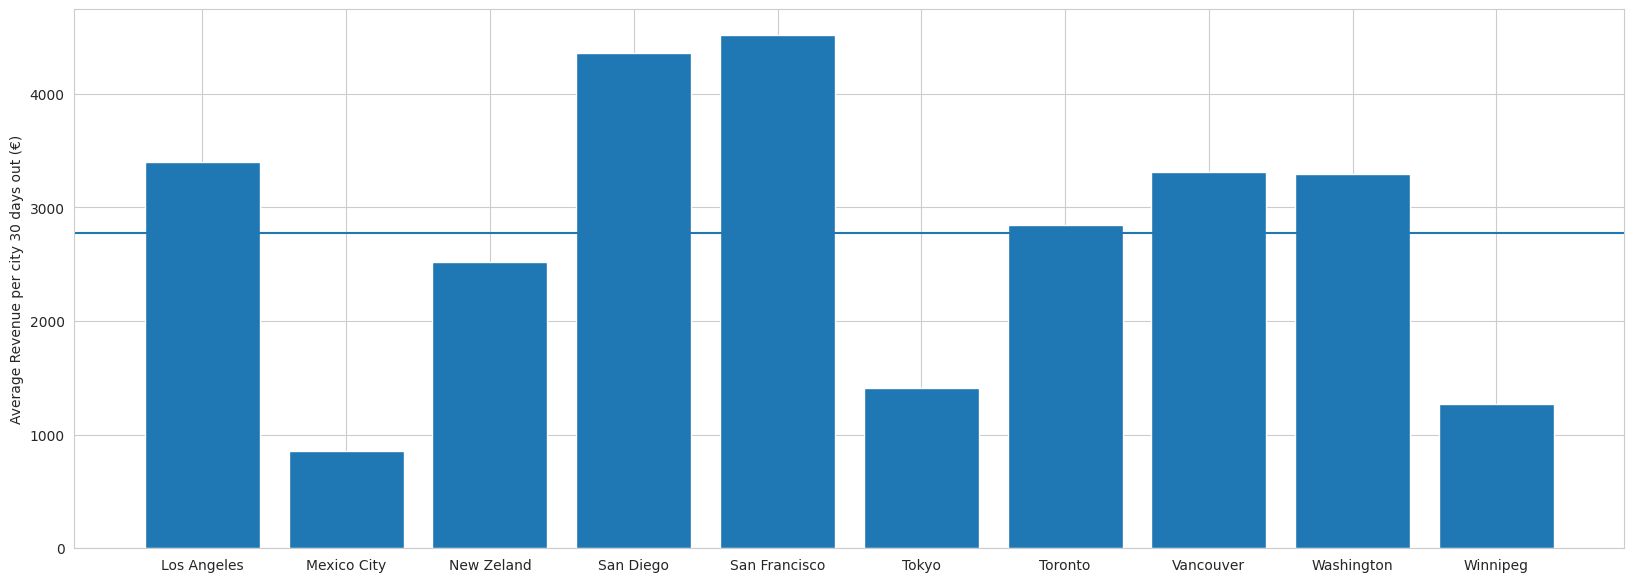

In [40]:
Avg_Rev_non_EUR_30 = pd.DataFrame(all_listings_non_Europe.groupby('City')['exp_rev_30'].mean().round(3))

fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 7))
axs.bar(Avg_Rev_non_EUR_30.index, Avg_Rev_non_EUR_30['exp_rev_30']);
axs.set_ylabel('Average Revenue per city 30 days out (€)');
axs.axhline(all_listings_non_Europe['exp_rev_30'].mean().round(3));

Based on this it seems (without any further analysis) that the expected revenue for airbnbs seems to be particularly high in US American and Canadian cities. Next we again perform a regression analysis to isolate the specific factors that explain expected revenue.

In [41]:
# Setting up data for running regression on non-European listings

# Select data for regression
reg_data_non_Europe = all_listings_non_Europe[['exp_rev_30', 'room_type', 'accommodates',
                                               'bedrooms', 'beds', 'price', 'minimum_nights', 'City']]

# Preprocess data for regression

# Drop rows with missing values to avoid potential bias from imputation
reg_data_non_Europe = reg_data_non_Europe.dropna().reset_index(drop=True)

# Target variable
reg_data_non_Europe_y = reg_data_non_Europe['exp_rev_30']

# Dummy encode categorical variables ('room_type' and 'City'), omitting the first category to avoid multicollinearity
reg_data_non_Europe_X_transform = pd.get_dummies(reg_data_non_Europe[["room_type", 'City']], drop_first=True)

# Select numerical variables
reg_data_non_Europe_X_not_transform = reg_data_non_Europe[['accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights']]

# Merge transformed and numerical variables
reg_data_non_Europe_X = pd.concat([reg_data_non_Europe_X_not_transform, reg_data_non_Europe_X_transform], axis=1)

# Replace True/False with 1/0 for regression
reg_data_non_Europe_X = reg_data_non_Europe_X.replace({True: 1, False: 0})

# Add constant to predictor variables for the regression model
reg_data_non_Europe_X = sm.add_constant(reg_data_non_Europe_X)

# Fit linear regression model
model_non_EUR = sm.OLS(reg_data_non_Europe_y, reg_data_non_Europe_X).fit()

# Display model summary
print(model_non_EUR.summary())

                            OLS Regression Results                            
Dep. Variable:             exp_rev_30   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     7189.
Date:                Thu, 19 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:35:19   Log-Likelihood:            -1.4494e+06
No. Observations:              152912   AIC:                         2.899e+06
Df Residuals:                  152894   BIC:                         2.899e+06
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    650

Interpretation some interesting regression results:

- firstly note that the model significantly improves upon the constant only model (see F-statistic)
- next interestingly notice that all coefficients of the regression (with one exception) are highly statistically significant
- unlike with europe an increase in accomodates is associated with a decrease in revenue, however an increase in bedroom is still associated with an increase in expected revenue
- it yields a higher expected return to rent out the entire place which we can find by the coefficients of the room_type varibles which are all negative which suggests that any of the three listed alternatives decreases the expected revenue compared to renting out the entire place (the omitted category for room_types to avoid into issues of multicollinearity)
- most importantly the coefficients of the city-dummies indicate the city specific impact on revenue by a specific city compared to Los Angeles (the omitted category), we can immediately see that the city specifc contribution to revenue is highest in San Fransico since its the most positive coefficient

NOTE: We will utilize the city-dummy coefficients later more (see Profitability Estimation + Investment Advice)

### **3.2) Profitability Estimation + Investment Advice**


Recall that the aim of this challenge was to obtain insights for investors to provide them investment advice, i.e. advice in terms of where to best invest into a property that could then be rented out as an airbnb.

So far we only analyzed the expected revenue that could be generated from having airbnbs in the previously mentiond cities. For an investor it is however elementary to also get an idea of the cost of investing into a place somewhere to then rent it out (airbnb). That is we now know the revenue side of the equation but not the cost one to then ultimately determine the potential profitiability which we need to give good investment advice. Since the provided data did not contain any indications of the prices of the places (i.e. any indications in terms of the value of the place) we looked up the average price per square meter in the city center as a proxy for how expensive the different cites are. In doing this we found the following data.

In [42]:
# Price per square meter in the city center (proxy for housing expenses in cities, in dollars)
ppsm_cc_dol = [
    9726.72, 5105.72, 4571.73, 15675.17, 4841.83, 5745.57, 9219.44, 5614.79,
    3726.53, 3724.66, 5452.09, 2061.41, 2715.17, 9294.59, 4130.82, 6063.46,
    7131.63, 4759.16, 9001.29, 11435.14, 9022.29, 9702.67, 3421.84, 9822.20,
    9258.71, 7882.02, 2986.71, 19172.27
]

# Create a DataFrame with city, continent, and price per square meter
property_prices_df = pd.DataFrame({
    'City': cities,
    'Continent': continents,
    'ppsm_cc_dol': ppsm_cc_dol
})

# Filter and sort data for European cities
property_prices_df_EUR = property_prices_df[property_prices_df['Continent'] == 'Europe'].sort_values(by='ppsm_cc_dol', ascending=False).reset_index(drop=True)

# Filter and sort data for non-European cities
property_prices_df_non_EUR = property_prices_df[property_prices_df['Continent'] == 'Non-Europe'].sort_values(by='ppsm_cc_dol', ascending=False).reset_index(drop=True)

# Sort the main DataFrame by price per square meter (descending)
property_prices_df = property_prices_df.sort_values(by='ppsm_cc_dol', ascending=False).reset_index(drop=True)

We can now use this data to rank the cities according to how expensive it is to buy property there (for the european and non-european cities separately). This is interesting since we can additionally look at the coefficients on the city-dummies earlier to also rank the cities according to how much revenue they generate and then look at the ranking of a city in both rankings to determine whether it is recommended to invest here.

sources:
- main source: https://www.numbeo.com/cost-of-living/city_price_rankings?itemId=100
- Euskadi (average Bilbao, Vitoria-Gasteiz and San Sebastián (Top 3 cities), reference Numbeo)
- ireland (Took average of Dublin, limerick  and Cork (Top 3 cities) Reference: Numbeo)
- malta (average Valletta, Cork and Sliema (Top 3 Cities))
- Menorca (Took Average Price of Most Dense Area, reference; https://www.housespain.co.uk/price-stats/islas_baleares-ciutadella_de_menorca.aspx , took Average Conversion Rate of November 2022: https://www.ofx.com/en-ie/forex-news/historical-exchange-rates/monthly-average-rates/ )
- New Zealand, Took average of Christchurch, Wellington and Auckland, reference: Numbeo)
- Washington D.C Reference: https://www.numbeo.com/property-investment/in/Washington
- Winnipeg: Reference: https://www.numbeo.com/property-investment/compare_cities.jsp?country1=Canada&city1=Winnipeg&country2=United+States&city2=Washington%2C+DC&displayCurrency=USD

For this we first look at the European cities.

In [43]:
# ranking prices of places within cities in Europe
property_prices_df_EUR

,City,Continent,ppsm_cc_dol
0,Zurich,Europe,19172.27
1,Geneva,Europe,15675.17
2,Amsterdam,Europe,9726.72
3,Milan,Europe,9294.59
4,Vienna,Europe,9258.71
5,Rome,Europe,7131.63
6,Lisbon,Europe,5745.57
7,Madrid,Europe,5614.79
8,Malta,Europe,5452.09
9,Barcelona,Europe,5105.72


In [44]:
# city specific dummy coefficients sorted by impact on profitability (Europe)
# Note: omitted category Amsterdam (basically has coefficient 0)
model_EUR.params[9:].sort_values(ascending=False)

,0
City_Rome,-842.48
City_Zurich,-1049.73
City_Mallorca,-1235.13
City_Lisbon,-1241.37
City_Rotterdam,-1250.50
City_Milan,-1261.97
City_Barcelona,-1434.26
City_Valencia,-1502.47
City_Vienna,-1530.09
City_Madrid,-1535.07


From combining these two rankings we can hence conclude the following, for the European cities we investigated:
- For investors with a lot of capital:
  - invest in a city such as Amsterdam, Zurich or Rome since they yield the highest expected returns, which of course comes at the cost of needing to have a lot of capital
- For investors with little to a medium amount of capital:
  - invest in a place like Mallorca cause the average prices are relatively low but one can still expect a relatively high expected return

From the regression results we can further conclude on specific characteristics of a potential place to invest into to maximize expected return potential (to then rent out as an airbnb):
  - choose a place with multiple bedrooms that allows to rent out the entire place

Next we do the same for the non-European cities

In [45]:
# ranking prices of places within cities outside Europe
property_prices_df_non_EUR

,City,Continent,ppsm_cc_dol
0,San Francisco,Non-Europe,11435.14
1,Vancouver,Non-Europe,9822.20
2,Toronto,Non-Europe,9702.67
3,Los Angeles,Non-Europe,9219.44
4,Tokyo,Non-Europe,9022.29
5,San Diego,Non-Europe,9001.29
6,Washington,Non-Europe,7882.02
7,New Zeland,Non-Europe,6063.46
8,Winnipeg,Non-Europe,2986.71
9,Mexico City,Non-Europe,2715.17


In [46]:
# city specific dummy coefficients sorted by impact on profitability (non-Europe)
# Note: omitted category Los Angeles (basically has coefficient 0)
model_non_EUR.params[9:].sort_values(ascending=False)

,0
City_San Francisco,1643.26
City_Washington,731.74
City_Vancouver,691.03
City_Toronto,544.04
City_San Diego,495.16
City_New Zeland,-36.67
City_Tokyo,-334.46
City_Winnipeg,-383.96
City_Mexico City,-570.39


From combining these two rankings we can hence conclude the following, for the non-European cities we investigated:
- For investors with a lot of capital:
  - invest in a city such as San Francisco or Vancouver since they yield the highest expected returns, which of course comes at the cost of needing to have a lot of capital
- For investors with little to a medium amount of capital:
  - invest in a place like Washington cause the average prices are relatively low but one can still expect a relatively high expected return

From the regression results we can further conclude on specific characteristics of a potential place to invest into to maximize expected return potential (to then rent out as an airbnb):
  - choose a place with multiple bedrooms that allows to rent out the entire place (hence very much similar to the European cities)